In [ ]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses most of TensorFlow's logging messages

import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import LearningRateScheduler#Warm‚Äëup: tuy·∫øn t√≠nh 2 epoch ƒë·∫ßu
from collections import defaultdict
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [2]:
# ƒê∆∞·ªùng d·∫´n th∆∞ m·ª•c input v√† output
input_dir = 'PlantVillage/data'

In [3]:
# setup cho ·∫£nh
SEED=123
IMAGE_SIZE= 256
BATCH_SIZE=16 # s·ªë l∆∞·ª£ng ·∫£nh m·ªói l·∫ßn hu·∫•n luy·ªán
CHANNELS=3


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    input_dir,
)
CLASS_NAMES=dataset.class_names

Found 21454 files belonging to 15 classes.


In [5]:
# ƒê·∫øm s·ªë l∆∞·ª£ng ph·∫ßn t·ª≠ trong m·ªói class
for class_name in CLASS_NAMES:
    print(f"{class_name}: {len(os.listdir(os.path.join(input_dir, class_name)))} images")

Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 968 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato_healthy: 1591 images


In [6]:
# Set seed cho reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [7]:
# T·∫°o train dataset (80%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    input_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed=SEED,
    validation_split=0.2,
    subset="training",
    label_mode="int"
)

Found 21454 files belonging to 15 classes.
Using 17164 files for training.


In [8]:
# T·∫°o val+test dataset (20%)
val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    input_dir,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    seed=SEED,
    validation_split=0.2,
    subset="validation",
    label_mode="int"
)

Found 21454 files belonging to 15 classes.
Using 4290 files for validation.


In [9]:
# Chia val+test th√†nh val (10%) v√† test (10%) v·ªõi c√πng seed
val_test_size = tf.data.experimental.cardinality(val_test_ds).numpy()
val_size = val_test_size // 2

val_ds = val_test_ds.take(val_size)
test_ds = val_test_ds.skip(val_size)

CLASS_NAMES = train_ds.class_names
print(f"Train batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Val batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_ds)}")

Train batches: 1073
Val batches: 134
Test batches: 135


In [10]:
# C√¢n b·∫±ng d·ªØ li·ªáu b·∫±ng class weights
from sklearn.utils.class_weight import compute_class_weight

# T√≠nh to√°n class weights
class_counts = []
for class_name in CLASS_NAMES:
    count = len(os.listdir(os.path.join(input_dir, class_name)))
    class_counts.append(count)

# T√≠nh class weights t·ª± ƒë·ªông
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(CLASS_NAMES)),
    y=np.repeat(np.arange(len(CLASS_NAMES)), class_counts)
)

# Chuy·ªÉn th√†nh dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class weights:")
for i, (class_name, weight) in enumerate(zip(CLASS_NAMES, class_weights)):
    print(f"{class_name}: {weight:.2f}")

Class weights:
Pepper__bell___Bacterial_spot: 1.43
Pepper__bell___healthy: 0.97
Potato___Early_blight: 1.43
Potato___Late_blight: 1.43
Potato___healthy: 1.48
Tomato_Bacterial_spot: 0.67
Tomato_Early_blight: 1.43
Tomato_Late_blight: 0.75
Tomato_Leaf_Mold: 1.50
Tomato_Septoria_leaf_spot: 0.81
Tomato_Spider_mites_Two_spotted_spider_mite: 0.85
Tomato__Target_Spot: 1.02
Tomato__Tomato_YellowLeaf__Curl_Virus: 0.45
Tomato__Tomato_mosaic_virus: 3.83
Tomato_healthy: 0.90


In [11]:
# Ti·ªÅn x·ª≠ l√Ω v√† shuffle d·ªØ li·ªáu
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(ds, shuffle=False):
    ds = ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess(train_ds, shuffle=True)
val_ds = preprocess(val_ds)
test_ds = preprocess(test_ds)

In [12]:
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomZoom(0.2),  # M√¥ ph·ªèng kho·∫£ng c√°ch ch·ª•p
    layers.RandomRotation(0.2), # Xoay nh·∫π ƒë·ªÉ m√¥ ph·ªèng g√≥c ch·ª•p
    layers.RandomTranslation(0.1, 0.1), # M√¥ ph·ªèng ·∫£nh ch·ª•p kh√¥ng ch√≠nh gi·ªØa.
])

In [ ]:
# S·ª≠ d·ª•ng EfficientNetB3 l√†m base model
base_model = tf.keras.applications.EfficientNetB3(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    include_top=False, 
    weights='imagenet',
)

# ƒê√≥ng bƒÉng c√°c layer c·ªßa base model
base_model.trainable = False
    
# T·∫°o m√¥ h√¨nh v·ªõi c√°c layer t·ªëi ∆∞u
model = tf.keras.Sequential([
    # Preprocessing layers
    augment,

    # Base model
    base_model,
    
    tf.keras.layers.BatchNormalization(),  # Th√™m Batch Normalization ƒë·ªÉ ·ªïn ƒë·ªãnh training
    
    # Th√™m c√°c l·ªõp m·ªõi v·ªõi s·ªë neural nhi·ªÅu h∆°n
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2), # Th√™m Dropout ƒë·ªÉ gi·∫£m overfitting
    
    # Dense layer v·ªõi L2 regularization ƒë·ªÉ gi·∫£m overfitting
    tf.keras.layers.Dense(
        64, activation='relu',
        kernel_regularizer=tf.keras.regularizers.l2(1e-5)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Output layer
    tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (16, 1536)               6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (16, 64)                  98368     
                                                                 
 dropout (Dropout)           (16, 64)                  0         
                                                                 
 dense_1 (Dense)             (16, 64)                  4160      
                                                      

In [ ]:
# Compile v·ªõi mixed precision ƒë·ªÉ tƒÉng t·ªëc ƒë·ªô training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-4
),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
csv_logger = tf.keras.callbacks.CSVLogger('training_log_efficient.csv', append=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model_efficient.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=True,  # Th√™m tham s·ªë n√†y
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Theo d√µi sai s·ªë tr√™n t·∫≠p validation
    patience=5,  # Cho ph√©p m√¥ h√¨nh "ch·ªØng" trong 10 epoch r·ªìi m·ªõi d·ª´ng
    restore_best_weights=True,  # Kh√¥i ph·ª•c l·∫°i tr·ªçng s·ªë c·ªßa epoch t·ªët nh·∫•t
    verbose=1, # V√¨ ƒëang theo d√µi accuracy (mu·ªën t·ªëi ƒëa)
    min_delta=0.001  # Th√™m min_delta ƒë·ªÉ ƒë·∫£m b·∫£o c·∫£i thi·ªán ƒë√°ng k·ªÉ

)
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs_efficient')

In [ ]:
# Train the model giai ƒëo·∫°n 1
callbacks = [reduce_lr, csv_logger, checkpoint, early_stopping, tensorboard]  
history1 = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight_dict
)

Epoch 1/10
1073/1073 [==============================] - ETA: 0s - loss: 2.2190 - accuracy: 0.3146
Epoch 1: val_loss improved from inf to 1.49744, saving model to best_model_efficient.keras
1073/1073 [==============================] - 351s 286ms/step - loss: 2.2190 - accuracy: 0.3146 - val_loss: 1.4974 - val_accuracy: 0.5462 - lr: 1.0000e-04
Epoch 2/10
1073/1073 [==============================] - ETA: 0s - loss: 1.4487 - accuracy: 0.5422
Epoch 2: val_loss improved from 1.49744 to 1.08293, saving model to best_model_efficient.keras
1073/1073 [==============================] - 336s 313ms/step - loss: 1.4487 - accuracy: 0.5422 - val_loss: 1.0829 - val_accuracy: 0.6735 - lr: 1.0000e-04
Epoch 3/10
1073/1073 [==============================] - ETA: 0s - loss: 1.1309 - accuracy: 0.6389
Epoch 3: val_loss improved from 1.08293 to 0.85697, saving model to best_model_efficient.keras
1073/1073 [==============================] - 365s 340ms/step - loss: 1.1309 - accuracy: 0.6389 - val_loss: 0.8570 - v

In [ ]:
# Unfreeze base model
base_model.trainable = True 

# Freeze c√°c layer ƒë·∫ßu 
for layer in base_model.layers[:300]:   # ƒê√≥ng bƒÉng 300 layer ƒë·∫ßu 
    layer.trainable = False 

In [18]:

warmup_epochs = 4
def lr_warmup(epoch, lr):
    if epoch < warmup_epochs:
        return 1e-5 * (epoch + 1) / warmup_epochs
    return 1e-5          # Gi·ªØ nguy√™n v·ªÅ sau (ho·∫∑c t·ª± gi·∫£m b·∫±ng ReduceLROnPlateau)

warmup_cb = LearningRateScheduler(lr_warmup, verbose=1)

In [19]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=1e-5
),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
# Train the model
callbacks = [warmup_cb,reduce_lr, csv_logger, checkpoint, early_stopping, tensorboard]
history2 =model.fit(
    train_ds,
    epochs=30,  
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


Epoch 1: LearningRateScheduler setting learning rate to 2.5e-06.
Epoch 1/30
1073/1073 [==============================] - ETA: 0s - loss: 1.2187 - accuracy: 0.6224
Epoch 1: val_loss did not improve from 0.41061
1073/1073 [==============================] - 466s 410ms/step - loss: 1.2187 - accuracy: 0.6224 - val_loss: 0.7993 - val_accuracy: 0.7416 - lr: 2.5000e-06

Epoch 2: LearningRateScheduler setting learning rate to 5e-06.
Epoch 2/30
1073/1073 [==============================] - ETA: 0s - loss: 0.8943 - accuracy: 0.7089
Epoch 2: val_loss did not improve from 0.41061
1073/1073 [==============================] - 441s 411ms/step - loss: 0.8943 - accuracy: 0.7089 - val_loss: 0.5719 - val_accuracy: 0.8223 - lr: 5.0000e-06

Epoch 3: LearningRateScheduler setting learning rate to 7.500000000000001e-06.
Epoch 3/30
1073/1073 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7641
Epoch 3: val_loss did not improve from 0.41061
1073/1073 [==============================] - 43

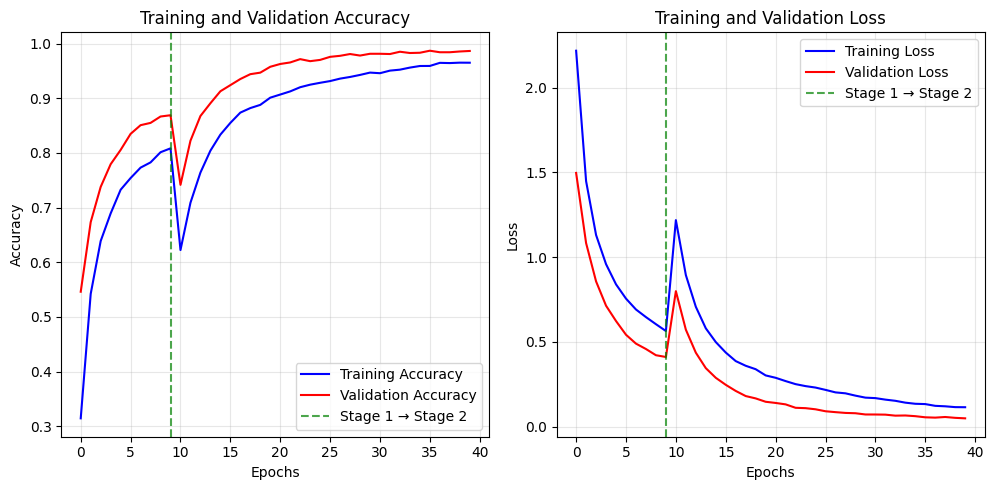


üìä TH·ªêNG K√ä TRAINING:
Giai ƒëo·∫°n 1 - Best Val Accuracy: 0.8689
Giai ƒëo·∫°n 2 - Best Val Accuracy: 0.9869


In [21]:
# K·∫øt h·ª£p history c·ªßa 2 giai ƒëo·∫°n
def combine_histories(hist1, hist2a):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2a.history[key]
    return combined

combined_history = combine_histories(history1, history2)

# V·∫Ω bi·ªÉu ƒë·ªì
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
epochs_stage1 = len(history1.history['accuracy'])
epochs_total = len(combined_history['accuracy'])

plt.plot(range(epochs_total), combined_history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(range(epochs_total), combined_history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.axvline(x=epochs_stage1-1, color='green', linestyle='--', alpha=0.7, label='Stage 1 ‚Üí Stage 2')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(range(epochs_total), combined_history['loss'], 'b-', label='Training Loss')
plt.plot(range(epochs_total), combined_history['val_loss'], 'r-', label='Validation Loss')
plt.axvline(x=epochs_stage1-1, color='green', linestyle='--', alpha=0.7, label='Stage 1 ‚Üí Stage 2')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In th·ªëng k√™
print(f"\nüìä TH·ªêNG K√ä TRAINING:")
print(f"Giai ƒëo·∫°n 1 - Best Val Accuracy: {max(history1.history['val_accuracy']):.4f}")
print(f"Giai ƒëo·∫°n 2 - Best Val Accuracy: {max(history2.history['val_accuracy']):.4f}")

First image to predict
Actual label:  Tomato_Bacterial_spot
Predicted label:  Tomato_Bacterial_spot


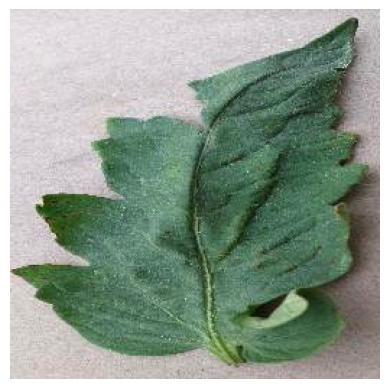

In [22]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0]
    first_label = labels_batch[0].numpy()
    
    # Chu·∫©n h√≥a ·∫£nh v·ªÅ kho·∫£ng [0, 1] ƒë·ªÉ hi·ªÉn th·ªã ƒë√∫ng
    image_to_show = first_image.numpy()
    image_to_show = (image_to_show - image_to_show.min()) / (image_to_show.max() - image_to_show.min())
    
    # Hi·ªÉn th·ªã ·∫£nh g·ªëc (deprocess ƒë·ªÉ tr√°nh ·∫£nh b·ªã t·ªëi)
    plt.imshow(image_to_show) 
    plt.axis("off")
    print("First image to predict")
    print("Actual label: ", CLASS_NAMES[first_label])
    
    batch_prediction = model.predict(images_batch, verbose=0)
    predicted_index = tf.math.argmax(batch_prediction[0]).numpy()
    print("Predicted label: ", CLASS_NAMES[predicted_index])


In [23]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array,verbose=0)
    predicted_class=CLASS_NAMES[tf.math.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

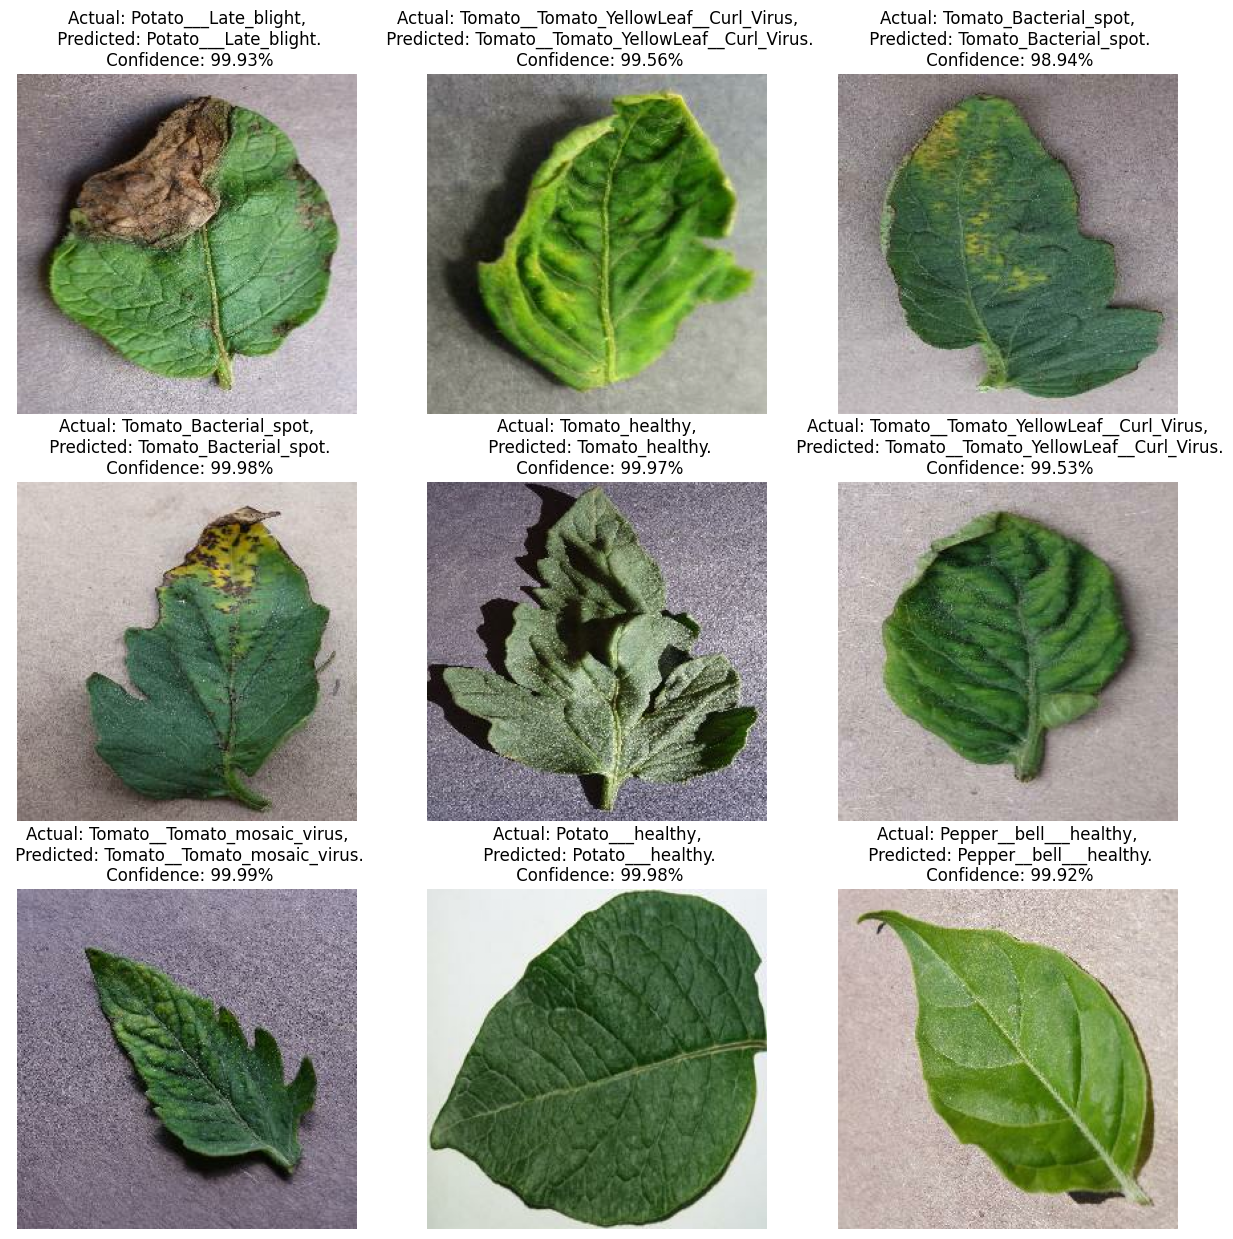

In [ ]:
plt.figure(figsize=(15,15))
for images_batch,labels_batch in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        # Reverse preprocess_input ƒë·ªÉ hi·ªÉn th·ªã ·∫£nh ƒë√∫ng
        image = images_batch[i].numpy()
        image = (image - image.min()) / (image.max() - image.min())
        
        plt.imshow(image)
        plt.axis("off")
        predicted_class,confidence=predict(model,images_batch[i].numpy())
        actual_class=CLASS_NAMES[labels_batch[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

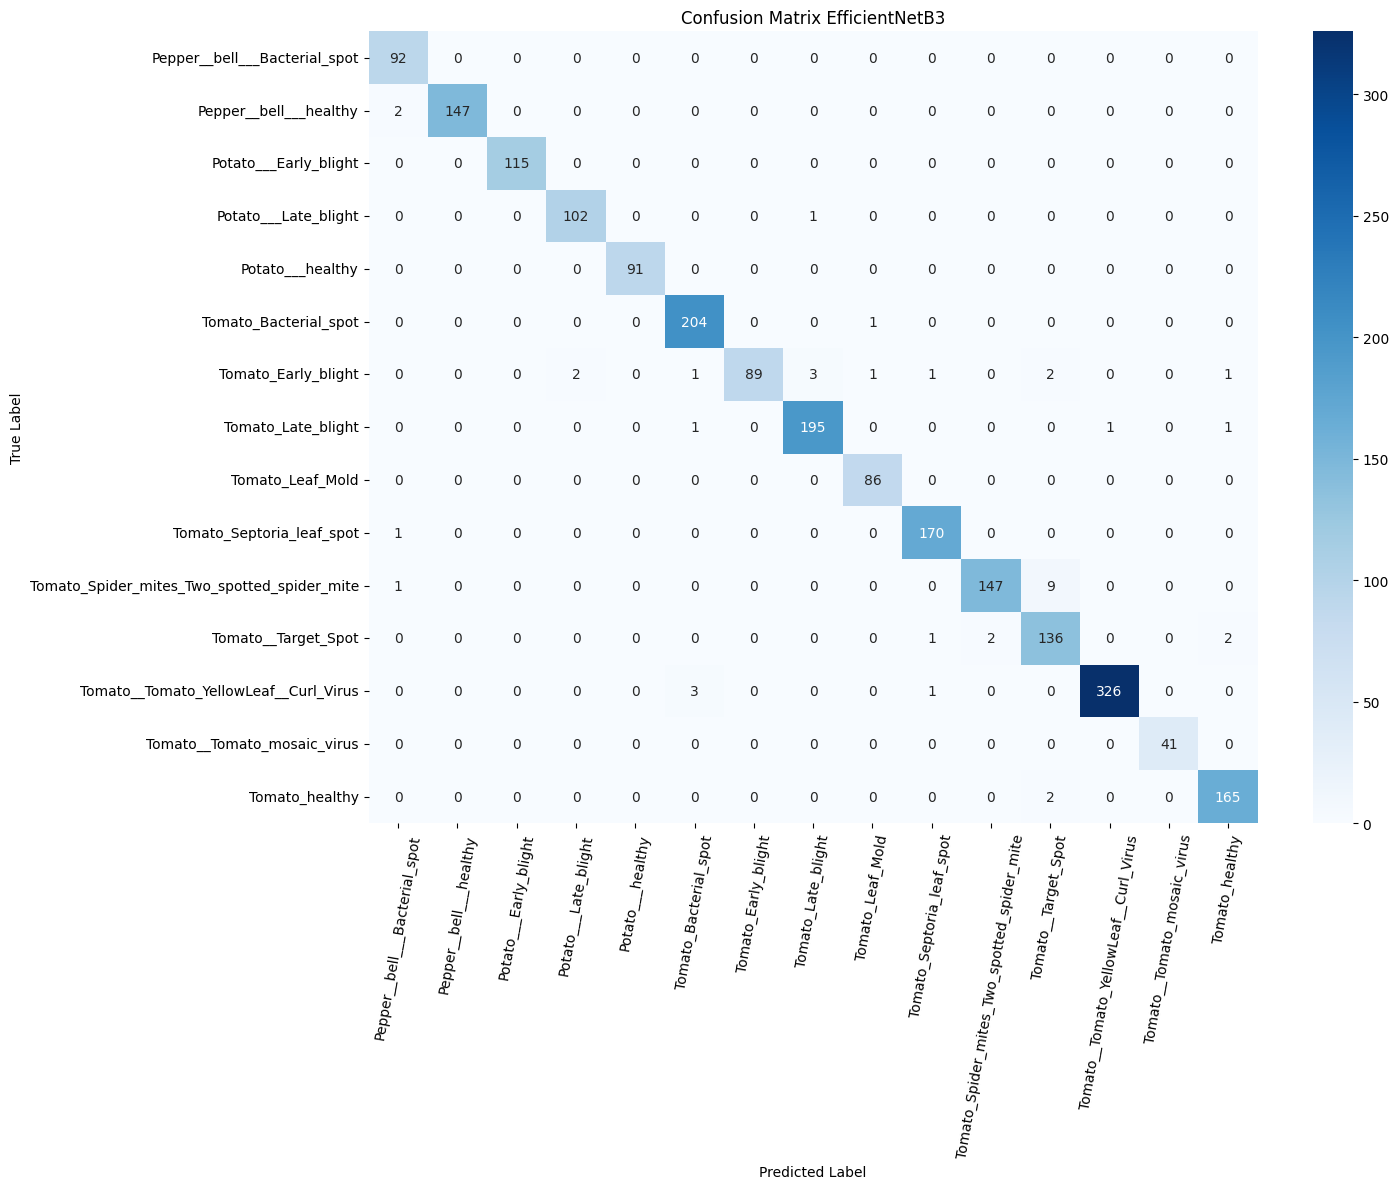

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# T·∫°o predictions cho to√†n b·ªô test dataset
y_pred = []
y_true = []

for images, labels in test_ds:
    # D·ª± ƒëo√°n cho batch hi·ªán t·∫°i
    batch_pred = model.predict(images, verbose=0)
    batch_pred = np.argmax(batch_pred, axis=1)

    # Th√™m v√†o danh s√°ch predictions v√† true labels
    y_pred.extend(batch_pred)
    y_true.extend(labels.numpy())

# T√≠nh confusion matrix
cm = confusion_matrix(y_true, y_pred)

# V·∫Ω confusion matrix s·ª≠ d·ª•ng seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES,
            yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix EfficientNetB3')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=80)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
test_loss,test_accuracy=model.evaluate(test_ds)
print(f'test loss: {test_loss}')
print(f'test accuracy: {test_accuracy}')

135/135 [==============================] - 22s 165ms/step - loss: 0.0545 - accuracy: 0.9814
test loss: 0.05451351776719093
test accuracy: 0.981360673904419


In [27]:

# T√≠nh to√°n c√°c metrics
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# In b·∫£ng th·ªëng k√™ ng·∫Øn g·ªçn
print("=== B·∫¢NG TH·ªêNG K√ä HI·ªÜU SU·∫§T MODEL ===")
print(f"Accuracy:  {accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")

=== B·∫¢NG TH·ªêNG K√ä HI·ªÜU SU·∫§T MODEL ===
Accuracy:  98.14%
Precision: 98.18%
Recall:    98.14%
F1-Score:  98.13%
